In [91]:
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler
import numpy as np

# read datasets
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

y1_name, y2_name, y3_name = "dir_costs", "traffic_costs_s_r", "lost_trips_costs_s_r"
train_y1, train_y2, train_y3 = train_df[y1_name], train_df[y2_name], train_df[y3_name]
test_y1, test_y2, test_y3 = test_df[y1_name], test_df[y2_name], test_df[y3_name]

# scale features
X_train = train_df.drop(columns=[y1_name, y2_name, y3_name])
scaler = MaxAbsScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

X_test = test_df.drop(columns=[y1_name, y2_name, y3_name])
X_test = scaler.transform(X_test)

# prepare dataset from training kmeans
X_train_y1 = np.concatenate((X_train, train_df[y1_name].values.reshape(-1, 1)), axis=1)
scaler_y1 = MaxAbsScaler()
scaler_y1.fit(X_train_y1)
X_train_y1 = scaler_y1.transform(X_train_y1)

<h1> Figure out optimal number of clusters (Elbov method) </h1>

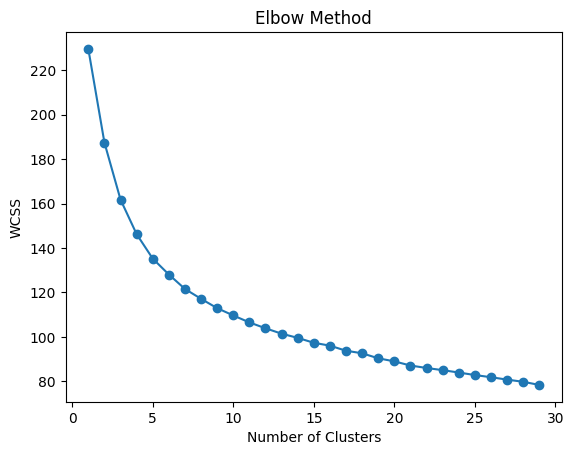

In [92]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a range of cluster numbers
cluster_range = range(1, 30)
wcss = []

# Calculate WCSS for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_train_y1)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

<h1> Train kmeans with y1 </h1>

In [133]:
from sklearn.cluster import KMeans

clusters_num = 2
kmeans = KMeans(n_clusters=clusters_num, random_state=42, n_init=10)
kmeans.fit(X_train_y1)

KMeans(n_clusters=2, n_init=10, random_state=42)

In [134]:
import numpy as np
# transforms X into clustered dataset with. k - number of clusters in the range [0, k-1]
def transform_to_clustered_dataset_train(X: np.ndarray, Xy: pd.DataFrame, cluster_predictor, k: int):
    clusters = cluster_predictor.predict(Xy)
    zero_columns = pd.DataFrame(np.zeros((X.shape[0], k)), columns=[f'class_{i}' for i in range(k)])
    res = np.concatenate((X, zero_columns), axis=1)
    for i in range(res.shape[0]):
        cluster = clusters[i]
        res[i, X.shape[1] + cluster] = 1.0 
    return res

def transform_to_clustered_dataset_test(X: np.ndarray, kmeans_model: KMeans, k: int):
    centers = kmeans_model.cluster_centers_[:, :-1]
    clusters = []
    for row in X:
        min_dist = np.Infinity
        cluster = -1
        for i in range(k):
            cur_dist = np.linalg.norm(row - centers[i])
            if cur_dist < min_dist:
                min_dist = cur_dist
                cluster = i
        if cluster == -1:
            raise "Error"
        clusters.append(cluster)
        
    zero_columns = pd.DataFrame(np.zeros((X.shape[0], k)), columns=[f'class_{i}' for i in range(k)])
    res = np.concatenate((X, zero_columns), axis=1)
    for i in range(res.shape[0]):
        cluster = clusters[i]
        res[i, X.shape[1] + cluster] = 1.0 
    return res
            

In [135]:
X_train_scaled_clustered = transform_to_clustered_dataset_train(X_train, X_train_y1, kmeans, clusters_num)
X_test_scaled_clustered = transform_to_clustered_dataset_test(X_test, kmeans, clusters_num)

In [136]:
X_train_scaled_clustered

array([[0.4847371 , 0.68466057, 0.2259446 , ..., 0.75      , 0.        ,
        1.        ],
       [0.47802333, 0.69168972, 0.22237944, ..., 0.625     , 0.        ,
        1.        ],
       [0.63943193, 0.70388019, 0.21250543, ..., 0.375     , 1.        ,
        0.        ],
       ...,
       [0.7129998 , 0.71451293, 0.44078162, ..., 0.625     , 1.        ,
        0.        ],
       [0.42912264, 0.7114071 , 0.20328418, ..., 0.625     , 1.        ,
        0.        ],
       [0.52636049, 0.69327397, 0.239317  , ..., 0.875     , 1.        ,
        0.        ]])

In [137]:
X_test_scaled_clustered

array([[0.86235051, 0.70819624, 0.30851162, ..., 0.625     , 1.        ,
        0.        ],
       [0.47028765, 0.70587462, 0.20004683, ..., 0.5       , 0.        ,
        1.        ],
       [0.68290034, 0.69656264, 0.19624861, ..., 0.625     , 1.        ,
        0.        ],
       ...,
       [0.53253457, 0.71117683, 0.24552313, ..., 0.5       , 0.        ,
        1.        ],
       [0.52389975, 0.70454701, 0.28990406, ..., 0.375     , 1.        ,
        0.        ],
       [0.5114943 , 0.67847473, 0.26538009, ..., 0.625     , 1.        ,
        0.        ]])

<h1> Pick sigma arbitrary <h1>

In [138]:
from GRNN import GRNN
from metrics import print_metrics

grnn_y1 = GRNN(sigma=0.066551824)
grnn_y1.fit(X_train_scaled_clustered, train_y1)

print("------ test metrics ------")
print_metrics(test_y1, grnn_y1.predict(X_test_scaled_clustered))


------ test metrics ------
Mean Squared Error (MSE):              38791028522034.1875000000
Root Mean Squared Error (RMSE):        6228244.4173325589
Mean Absolute Error (MAE):             4168481.9760489734
R-squared (R²):                        0.7984132549
Mean Absolute Percentage Error (MAPE): 0.1072627728
Max Error (ME):                        28070573.8191479295
Median Absolute Error (MedAE):         2657848.5117016546


<h2> Optimize sigma with differential evolution<h2>

In [116]:
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution

# define objective function
def objective_function(sigma, train_X, train_y, test_X, test_y):
    grnn = GRNN(sigma=sigma[0])
    grnn.fit(train_X, train_y)
    pred_y = grnn.predict(test_X)
    r2 = r2_score(test_y, pred_y)
    return -r2

<h1> Y1 (GRNN) </h1>

In [126]:
optimization_res = differential_evolution(func=objective_function, 
                                          bounds=[(0, 10)], 
                                          updating='deferred',
                                          workers=10, 
                                          disp=True,
                                          tol=0.0000001,
                                          atol=0.0000001,
                                          args=(X_train_scaled_clustered, train_y1, X_test_scaled_clustered, test_y1))
print(optimization_res)
print("Optimal sigma_y1: {:.{}f}".format(optimization_res.x[0], 9))

Process ForkPoolWorker-69:
Process ForkPoolWorker-63:
Process ForkPoolWorker-67:
Process ForkPoolWorker-70:
Process ForkPoolWorker-64:
Process ForkPoolWorker-62:
Process ForkPoolWorker-66:
Process ForkPoolWorker-68:
Process ForkPoolWorker-61:


KeyboardInterrupt: 

In [139]:
from GRNN import GRNN
from metrics import print_metrics

grnn_y1 = GRNN(sigma=0.066262205)
grnn_y1.fit(X_train_scaled_clustered, train_y1)

print("------ test metrics ------")
print_metrics(test_y1, grnn_y1.predict(X_test_scaled_clustered))

------ test metrics ------
Mean Squared Error (MSE):              38790262862895.2500000000
Root Mean Squared Error (RMSE):        6228182.9503391478
Mean Absolute Error (MAE):             4167333.7787603512
R-squared (R²):                        0.7984172338
Mean Absolute Percentage Error (MAPE): 0.1071935467
Max Error (ME):                        28118393.0088574663
Median Absolute Error (MedAE):         2671707.0512889698


<h1> Y1: (Gradient Boosting)</h1>

In [140]:
from sklearn.ensemble import GradientBoostingRegressor

# Create an instance of GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the regressor to the training data
gb_regressor.fit(X_train_scaled_clustered, train_y1)

print("------ test metrics ------")
print_metrics(test_y1, grnn_y1.predict(X_test_scaled_clustered))

print("------ train metrics ------")
print_metrics(train_y1, grnn_y1.predict(X_train_scaled_clustered))


------ test metrics ------
Mean Squared Error (MSE):              38790262862895.2500000000
Root Mean Squared Error (RMSE):        6228182.9503391478
Mean Absolute Error (MAE):             4167333.7787603512
R-squared (R²):                        0.7984172338
Mean Absolute Percentage Error (MAPE): 0.1071935467
Max Error (ME):                        28118393.0088574663
Median Absolute Error (MedAE):         2671707.0512889698
------ train metrics ------
Mean Squared Error (MSE):              9988788175565.2578125000
Root Mean Squared Error (RMSE):        3160504.4178999746
Mean Absolute Error (MAE):             1795272.4475584396
R-squared (R²):                        0.9584553859
Mean Absolute Percentage Error (MAPE): 0.0493759905
Max Error (ME):                        20762711.0879589915
Median Absolute Error (MedAE):         964626.1303383242


<h1> Optimize Gradient boost parameters using Differential evolution</h1>

In [141]:
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution

# define objective function
def objective_function(params, train_X, train_y, test_X, test_y):
    regressor = GradientBoostingRegressor(n_estimators=int(params[0]), learning_rate=params[1], max_depth=int(params[2]), random_state=42)
    regressor.fit(train_X, train_y)
    pred_y = regressor.predict(test_X)
    r2 = r2_score(test_y, pred_y)
    return -r2

In [142]:
optimization_res = differential_evolution(func=objective_function, 
                                          bounds=[(2, 300), (0.0001, 0.5), (2, 10)], 
                                          updating='deferred',
                                          workers=10, 
                                          disp=True,
                                          tol=0.0000001,
                                          atol=0.0000001,
                                          args=(X_train_scaled_clustered, train_y1, X_test_scaled_clustered, test_y1))
print(optimization_res)

differential_evolution step 1: f(x)= -0.881179
differential_evolution step 2: f(x)= -0.882189
differential_evolution step 3: f(x)= -0.882189
differential_evolution step 4: f(x)= -0.882279
differential_evolution step 5: f(x)= -0.885905
differential_evolution step 6: f(x)= -0.885905
differential_evolution step 7: f(x)= -0.885905
differential_evolution step 8: f(x)= -0.885905
differential_evolution step 9: f(x)= -0.885905
differential_evolution step 10: f(x)= -0.885905
differential_evolution step 11: f(x)= -0.885905
differential_evolution step 12: f(x)= -0.885905
differential_evolution step 13: f(x)= -0.885905
differential_evolution step 14: f(x)= -0.885905
differential_evolution step 15: f(x)= -0.885905
differential_evolution step 16: f(x)= -0.885905
differential_evolution step 17: f(x)= -0.885905
differential_evolution step 18: f(x)= -0.885905
differential_evolution step 19: f(x)= -0.885905
differential_evolution step 20: f(x)= -0.885905
differential_evolution step 21: f(x)= -0.885905
d

Process ForkPoolWorker-95:


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Create an instance of GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the regressor to the training data
gb_regressor.fit(X_train_scaled_clustered, train_y1)

print("------ test metrics ------")
print_metrics(test_y1, grnn_y1.predict(X_test_scaled_clustered))

print("------ train metrics ------")
print_metrics(train_y1, grnn_y1.predict(X_train_scaled_clustered))